In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
from copy import deepcopy
import glob
from pyuvdata import UVCal
from pyuvdata import UVData
from hera_cal import omni
from hera_cal import firstcal
from hera_qm.datacontainer import DataContainer
%matplotlib notebook 

# Load Data

In [2]:
pols = ['xx','xy','yx','yy']
JD = '2457757.47316' #well calibrated in IDR1
#JD = '2457757.59147' #some bad times
#JD = '2457790.25046' #very bad firstcal
#JD = '2457678.26437' #For aaron

datafiles, firstcalfiles, dataORfiles, badants = {},{},{},{}

for pol in pols:
    datafiles[pol] = '/data4/paper/HERA2015/'+JD.split('.')[0]+'/zen.'+JD+'.'+pol+'.HH.uvc' #works well    
    if pol is 'xx' or pol is 'yy':
        badantfile = datafiles[pol].replace('/zen','/IDR1/zen') + '.badants.txt'
        firstcalfiles[pol] = datafiles[pol].replace('/zen','/IDR1/zen') + '.first.calfits'
        dataORfiles[pol] = datafiles[pol].replace('/zen','/IDR1/zen') + 'OR'    
        try: badants[pol] = list(np.loadtxt(badantfile, delimiter=','))
        except: badants[pol] = [int(np.loadtxt(badantfile, delimiter=','))]

data = {}
for pol in pols:
    uv_in = UVData()
    uv_in.read_miriad(datafiles[pol])
    datapack, wgtpack = firstcal.UVData_to_dict([uv_in])
    if len(data) == 0: 
        data = datapack
    else:
        for key in datapack: data[key].update(datapack[key])

freqs = (uv_in.freq_array)/1e9 #GHz

Altitude is not present in Miriad file, using known location values for HERA.
antenna number 112 has visibilities associated with it, but it has a position of (0,0,0)


In [3]:
# for pol in pols:
#     uv_in = UVData()
#     uv_in.read_miriad(datafiles[pol])
#     print uv_in.baseline_array
#     print uv_in.data_array.shape
# #    print datapack, wgtpack = omni.UVData_to_dict([uv_in])

# print sorted(np.unique(np.append(uv_in.ant_1_array, uv_in.ant_2_array)))
# print uv_in.select(ant_pairs_nums=(9,22), inplace=False).data_array[:,0,:,0]
# uv_in.Nants_data

In [4]:
def ComputePerAntennaModifiedZScores(metric):
    '''TODO: Document'''
    zscores = {}    
    antpols = set([key[1] for key in metric.keys()])
    for antpol in antpols:            
        values = np.array([val for key,val in metric.items() if key[1]==antpol])
        median = np.nanmedian(values)
        medAbsDev = np.nanmedian(np.abs(values - median))
        for key,val in metric.items(): 
            if key[1]==antpol:
                zscores[key] = 0.6745*(val - median) / medAbsDev 
                #this factor makes it comparable to a standard z-score for gaussian data
    return zscores


# Mean Vij Technique

In [5]:
def CalulateMeanVijMetric(data, pols=None, xants=[], rawMetric=False):
    '''Calculates how an antennas's average |Vij| deviates from others.
    
    Arguments:
    data -- Dictionary (indexed by antenna pair) of dictionaries (index by polarization.)
    pols -- Visibility polarizations (e.g. 'xx' or 'xy'). Default, use all types found in data.
    xants -- list of antennas in the (ant,antpol) format that should be ignored.
    rawMetric -- return the raw mean Vij metric instead of the modified z-score
    
    Returns:
    meanMetrics -- a dictionary indexed by (ant,antpol) of the modified z-score of the mean of the 
    absolute value of all visibilities associated with an antenna. Very small or very large numbers 
    are probably bad antennas.
    '''
    
    #Get relevant info about array from data
    dc = DataContainer(data)
    if pols is None: pols = list(dc.pols())
    ants = sorted(list(set([bl[0] for bl in dc.bls()]).union(set([bl[1] for bl in dc.bls()]))))
    antpols = list(set(''.join(pols)))
    
    #Compute mean abs over time and frequency
    absVijMean = {(ant,antpol):0.0 for ant in ants for antpol in antpols if (ant,antpol) not in xants}
    visCounts = {(ant,antpol):0 for ant in ants for antpol in antpols if (ant,antpol) not in xants}
    for (i,j) in dc.bls():
        if i != j:
            for pol in pols:
                for ant, antpol in zip((i,j), pol):
                    if (ant,antpol) not in xants:
                        absVijMean[(ant,antpol)] += np.abs(dc[i,j,pol])
                        visCounts[(ant,antpol)] += 1
    timeFreqMeans = {}
    for key in absVijMean.keys():
        timeFreqMeans[key] = np.nanmean(absVijMean[key] / visCounts[key])
    
    if rawMetric: 
        return timeFreqMeans
    else: 
        return ComputePerAntennaModifiedZScores(timeFreqMeans)

## Plot Mean Vij

<IPython.core.display.Javascript object>


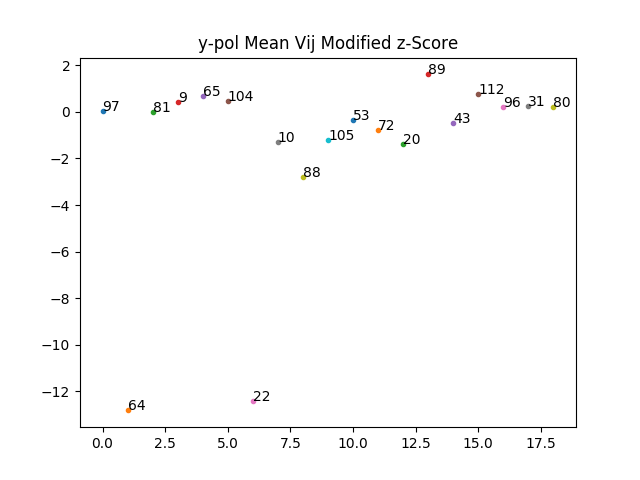

<IPython.core.display.Javascript object>


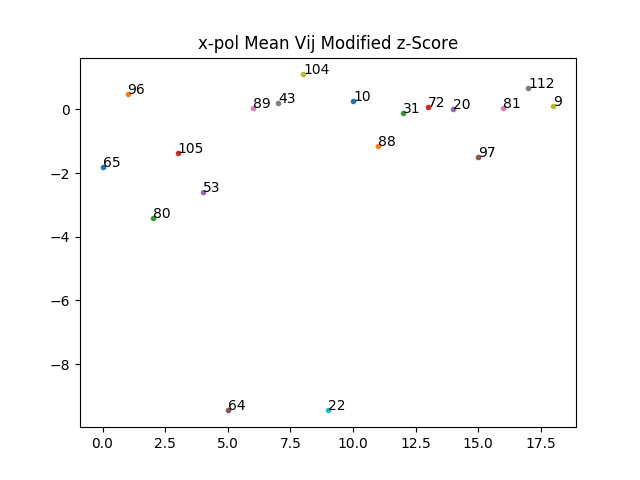

In [6]:
meanVijMetrics = CalulateMeanVijMetric(data)
#meanVijMetrics = CalulateMeanVijMetric(data, xants=[(22,'y')])
#meanVijMetrics = CalulateMeanVijMetric(data, pols=['xx','yy'])
#meanVijMetrics = CalulateMeanVijMetric(data, pols=['xy','yx'])
pols = data.values()[0].keys()
antpols = list(set(''.join(pols)))
for antpol in antpols:
    plt.figure()
    i = 0
    for key,metric in meanVijMetrics.items():
        if key[1]==antpol:
            plt.plot(i, metric, '.')
            plt.annotate(key[0],xy=(i,metric))
            i += 1
        plt.title(antpol + '-pol Mean Vij Modified z-Score')

# Non-Redundancy Technique

In [7]:
def CalculatePowerRedundancy(data, reds, pols=None, xants=[], rawMetric=False, crossPol=False):
    '''Calculates how an antenna's average power in redundant baselines it participates in deviates from others.
    
    Arguments:
    data -- Dictionary (indexed by antenna pair) of dictionaries (index by polarization.)
    pols -- Visibility polarizations (e.g. 'xx' or 'xy'). Default, use all types found in data.
    xants -- list of antennas in the (ant,antpol) format that should be ignored.
    rawMetric -- return the raw power correlations instead of the modified z-score
    crossPol -- return results only when the polarization of V1 and the polarization of V2 differ by a single flip
    
    Returns:
    powerRedMetric -- a dictionary indexed by (ant,antpol) of the modified z-scores of the mean 
    power correlations inside redundant baseline groups that the antenna participates in.
    Very small numbers are probably bad antennas.
    '''
    
    #Get relevant arrays from data
    dc = DataContainer(data)
    if pols is None: pols = list(dc.pols())
    ants = sorted(list(set([bl[0] for bl in dc.bls()]).union(set([bl[1] for bl in dc.bls()]))))
    antpols = list(set(''.join(pols)))
    

    #Precompute auto-powers to save time
    autoPower ={} 
    for pol in pols:
        for bls in reds:
            for bl in bls:
                autoPower[bl[0],bl[1],pol] = np.median(np.sum(np.abs(dc.get(bl,pol))**2, axis=0))
    
    #Compute power correlations and assign them to each antenna
    antCorrs = {(ant,antpol):0.0 for ant in ants for antpol in antpols if (ant,antpol) not in xants}
    antCounts = {(ant,antpol):0 for ant in ants for antpol in antpols if (ant,antpol) not in xants}
    
    for pol0 in pols:
        for pol1 in pols:
            iscrossed_i = (pol0[0] != pol1[0])
            iscrossed_j = (pol0[1] != pol1[1])
            onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
            #This function can instead record correlations for antennas whose counterpart are pol-swapped
            if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
                for bls in reds:
                    for n,(ant0_i,ant0_j) in enumerate(bls):
                        data0 = dc.get((ant0_i,ant0_j),pol0)
                        for (ant1_i,ant1_j) in bls[n+1:]:
                            data1 = dc.get((ant1_i,ant1_j),pol1)
                            corr = np.median(np.abs(np.sum(data0*data1.conj(), axis=0)))
                            corr /= np.sqrt(autoPower[ant0_i,ant0_j,pol0] * autoPower[ant1_i,ant1_j,pol1])
                            antsInvolved = [(ant0_i,pol0[0]), (ant0_j,pol0[1]), (ant1_i,pol1[0]), (ant1_j,pol1[1])]
                            if not np.any([(ant,antpol) in xants for ant,antpol in antsInvolved]):
                                #Only record the crossed antenna if i or j is crossed
                                if crossPol and iscrossed_i:
                                    antsInvolved = [(ant0_i,pol0[0]), (ant1_i,pol1[0])]
                                elif crossPol and iscrossed_j:
                                    antsInvolved = [(ant0_j,pol0[1]), (ant1_j,pol1[1])]
                                for ant,antpol in antsInvolved:
                                    antCorrs[(ant,antpol)] += corr
                                    antCounts[(ant,antpol)] += 1   
    
    #Compute average
    for key,count in antCounts.items():
        if count > 0: antCorrs[key] /= count
    
    if rawMetric:
        return antCorrs
    else:
        return ComputePerAntennaModifiedZScores(antCorrs)

## Plot Power Correlation Metric

<IPython.core.display.Javascript object>


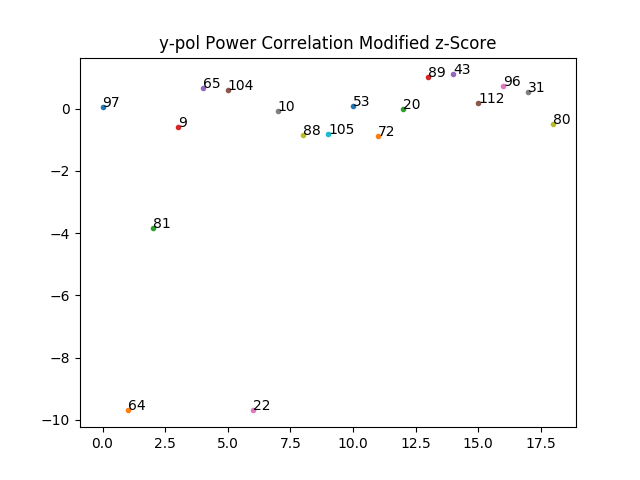

<IPython.core.display.Javascript object>


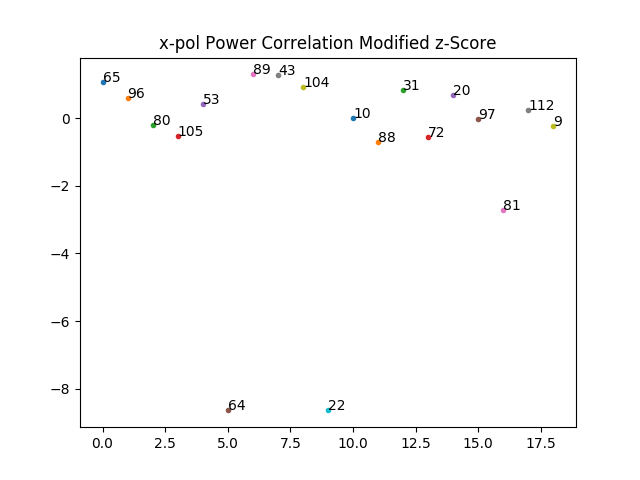

In [8]:
aa = a.cal.get_aa('hsa7458_v001', freqs)
info = omni.aa_to_info(aa, pols=[pol[0]], crosspols=[pol])
reds = info.get_reds()
powerRedMetric = CalculatePowerRedundancy(data,reds, pols=['xx','yy'])#, xants=[(64,'y'),(64,'x'),(22,'x'),(22,'y')])

pols = data.values()[0].keys()
antpols = list(set(''.join(pols)))
for antpol in antpols:
    plt.figure()
    i = 0
    for key,metric in powerRedMetric.items():
        if key[1]==antpol:
            plt.plot(i, metric, '.')
            plt.annotate(key[0],xy=(i,metric))
            i += 1
        plt.title(antpol + '-pol Power Correlation Modified z-Score')

# Find Crosspols based on mean Vijs

<IPython.core.display.Javascript object>


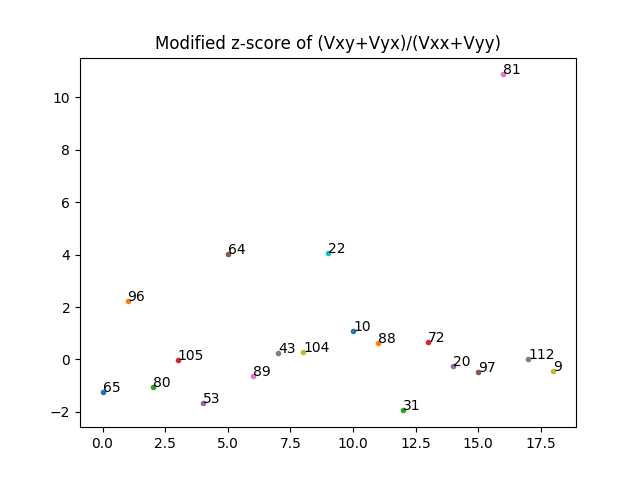

In [9]:
meanVijMetricsSame = CalulateMeanVijMetric(data, pols=['xx','yy'], rawMetric=True)
meanVijMetricsCross = CalulateMeanVijMetric(data, pols=['xy','yx'], rawMetric=True)

antpols = ['x','y']
ants = sorted(set([key[0] for key in meanVijMetricsSame.keys()]))
crossPolRatio = {}
for ant in ants:
    crossSum = np.sum([meanVijMetricsCross[(ant,antpol)] for antpol in antpols])
    meanSum = np.sum([meanVijMetricsSame[(ant,antpol)] for antpol in antpols])
    for antpol in antpols: 
        crossPolRatio[(ant,antpol)] = crossSum/meanSum

crossPolModifiedz = ComputePerAntennaModifiedZScores(crossPolRatio)

plt.figure()
i = 0
for (ant,antpol),metric in crossPolModifiedz.items():
    if antpol is 'x':
        plt.plot(i, metric, '.')
        plt.annotate(ant,xy=(i,metric))
        i += 1
plt.title('Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

# Find Crosspols based on power correlation

<IPython.core.display.Javascript object>


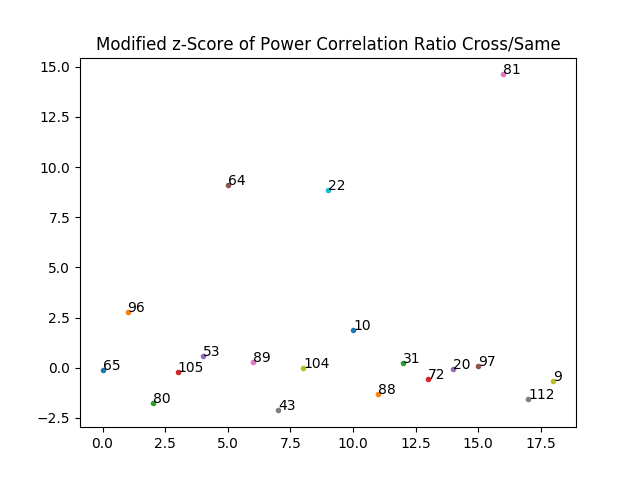

In [27]:
aa = a.cal.get_aa('hsa7458_v001', freqs)
info = omni.aa_to_info(aa, pols=[pol[0]], crosspols=[pol])
reds = info.get_reds()
powerRedMetricsSame = CalculatePowerRedundancy(data,reds, pols=['xx','yy'], rawMetric=True)
powerRedMetricsCross = CalculatePowerRedundancy(data,reds, pols=['xy','yx','yy'], crossPol=True, rawMetric=True)

antpols = ['x','y']
ants = sorted(set([key[0] for key in powerRedMetricsSame.keys()]))
crossPolRatio = {}
for ant in ants:
    cross = np.sum([powerRedMetricsCross[(ant,antpol)] for antpol in antpols])
    same = np.sum([powerRedMetricsSame[(ant,antpol)] for antpol in antpols])
    for antpol in antpols: 
        crossPolRatio[(ant,antpol)] = cross/same

crossPolModifiedz = ComputePerAntennaModifiedZScores(crossPolRatio)

plt.figure()
i = 0
for (ant,antpol),metric in crossPolModifiedz.items():
    if antpol is 'x':
        plt.plot(i, metric, '.')
        plt.annotate(ant,xy=(i,metric))
        i += 1
plt.title('Modified z-Score of Power Correlation Ratio Cross/Same')

# TODO for script:

* Save both metrics and z-scores
* Save value per antenna on last iteration that it was involved
* Also ouput bad antennas with save and read functions inside vismetrics
* perhaps also include initial metrics for all antennas
* hera_qm will support iterative flagging/metrology (Josh)
* output dict with key=(i,j,ipol,jpol), vals = {beginning=(metric,mod z score), end=(metric,mod z score, iteration flagged)} (Josh)
* metrics.{write,read}_metrics (Josh)
